### File Explanation

**trainRNN_ANM_HBTRC_AttentionModel.ipynb:**
<br> This notebook is to load AddNeuroMed examples from 'preprocessData.pickle', and HBTRC examples from 'preprocessData_HBTRC.pickle' and create an "Attention Network". Train the network on AddNeuroMed data set and test on HBTRC data set

**Variables information**:
<br> 1) Variables in the format of xxx_A represents data from AddNeuroMed
<br> 2) Variables in the format of xxx_H represents data from HBTRC

**Processes are as follows:**
<br> 1) Load all variables from 'preprocessData.pickle' and 'preprocessData_HBTRC.pickle'
<br> 2) Parameter and hyperparameter assignments (location: **3rd cell**)
<br> 3) Create LSTM cells with Dropout Wrappers for gene A and gene B (function: **dropoutWrapper** in **trainRNN_network_utils.py**)
<br> 4) Using LSTM cells, create multi-layer dynamic model from fixed length sequences (function: **dynamicLSTM_Attention** in **trainRNN_network_utils.py**)
<br> 5) Create an attention mechanism based on a fully-connected layer of states and output, which is followed by a tanh layer to calculate score. Then, calculate attention weights and context vector using softmax and dense layers 
<br> 6) Create a single output from a concatenation of context vectors of gene A and gene B
<br> 7) Pass the output through a **dense** layer and make prediction
<br> 8) Before starting the training: concatenate rSnpG_tr_nXSN and rRnaG_nXS where G represents gene A and gene B (function: **input_reshape** in **trainRNN_utils.py**)
<br> 9) Train the network: every epoch (i.e., iteration) shuffle the data within each class (function: **shuffle_classes** in **trainRNN_utils.py**) and train in batches (function: **extract_batch_size** in **trainRNN_utils.py**)
<br> 10) Plot results with **plot_one_input** in **trainRNN_plot_utils.py**)
<br> 11) Save them in "resultsAttention_ANM_HBTRC.pickle" to be called when necessary

**Variables created:**
<br> 1) **trainLosses**: Train losses, dictionary, keys of (dropout)
<br> 2) **testLosses**: Test losses, dictionary, keys of (dropout)
<br> 3) **F1_scores**: F1_scores, dictionary, keys of (dropout)
<br> 4) **trainAccuracy**: Train accuracy, dictionary, keys of (dropout)
<br> 5) **attention_matrixA**: Attention weights of gene A, dictionary, keys of (dropout)
<br> 6) **attention_matrixB**: Attention weights of gene B, dictionary, keys of (dropout)
<br> 7) **tst_prediction**: Test predictions, dictionary, keys of (dropout)

In [2]:
import tensorflow as tf
from IPython.core.debugger import set_trace
import numpy as np
import sys
import pandas as pd
from tensorflow.contrib import rnn
import matplotlib.pyplot as plt

import os
os.environ[ "CUDA_VISIBLE_DEVICES" ] = "3"

%matplotlib inline

In [1]:
# LOAD AddNeuroMed DATA
# Load data form the pickle produced by "preprocessData.ipynb" in AddNeuroMed folder

# Save data into Python file
import pickle
with open('../AddNeuroMed/preprocessData.pickle', 'rb') as f:
    rSnpA_nXSN_A = pickle.load( f )
    rSnpB_nXSN_A = pickle.load( f )
    rRnaA_nXS_A = pickle.load( f )
    rRnaB_nXS_A = pickle.load( f )
    rRelated_nXC_A = pickle.load( f )
    rSnpA_tr_nXSN_A = pickle.load( f )
    rSnpB_tr_nXSN_A = pickle.load( f )
    rRnaA_tr_nXS_A = pickle.load( f )
    rRnaB_tr_nXS_A = pickle.load( f )
    rRelated_tr_nXC_A = pickle.load( f )
    rSnpA_tst_nXSN_A = pickle.load( f )
    rSnpB_tst_nXSN_A = pickle.load( f )
    rRnaA_tst_nXS_A = pickle.load( f )
    rRnaB_tst_nXS_A = pickle.load( f )
    rRelated_tst_nXC_A = pickle.load( f )
    sGeneNames_nX2_A = pickle.load( f )
    nRs_A = pickle.load( f )
    nSs_A = pickle.load( f )
    print( 'AddNeuroMed data loaded from pickle.' )


# Check the input dimensions
assert( len( rSnpA_nXSN_A.shape ) == 3 )
assert( len( rSnpB_nXSN_A.shape ) == 3 )
assert( len( rRnaA_nXS_A.shape ) == 2 )
assert( len( rRnaB_nXS_A.shape ) == 2)
assert( len( rRelated_nXC_A.shape ) == 2 )
assert( len( rSnpA_tr_nXSN_A.shape ) == 3 )
assert( len( rSnpB_tr_nXSN_A.shape ) == 3 )
assert( len( rRnaA_tr_nXS_A.shape ) == 2 )
assert( len( rRnaB_tr_nXS_A.shape ) == 2 )
assert( len( rRelated_tr_nXC_A.shape ) == 2 )
assert( len( rSnpA_tst_nXSN_A.shape ) == 3 )
assert( len( rSnpB_tst_nXSN_A.shape ) == 3 )
assert( len( rRnaA_tst_nXS_A.shape ) == 2 )
assert( len( rRnaB_tst_nXS_A.shape ) == 2 )
assert( len( rRelated_tst_nXC_A.shape ) == 2)
assert( rSnpA_nXSN_A.shape[ 0 ] == rRnaA_nXS_A.shape[0] )
assert( rSnpA_nXSN_A.shape[ 0 ] == rRnaB_nXS_A.shape[0] )
assert( rSnpB_nXSN_A.shape[ 0 ] == rRnaA_nXS_A.shape[0] )
assert( rSnpB_nXSN_A.shape[ 0 ] == rRnaB_nXS_A.shape[0] )
assert( rSnpA_nXSN_A.shape[ 0 ] == rRelated_nXC_A.shape[ 0 ] )
assert( rSnpA_nXSN_A.shape[ 1 ] == rRnaA_nXS_A.shape[ 1 ] )
assert( rSnpB_nXSN_A.shape[ 1 ] == rRnaB_nXS_A.shape[ 1 ] )
assert( rRelated_nXC_A.shape[ 1 ] == 3 )

iSnum_A = rSnpA_nXSN_A.shape[ 1 ] # Number of subjects
iNnum_A = rSnpA_nXSN_A.shape[ 2 ] # Number of snps
iCnum_A = rRelated_nXC_A.shape[ 1 ] # Number of classes

print('All AddNeuroMed samples loaded.' )
print('Number of training samples (transcripts) of gene A: {}'.format( rSnpA_tr_nXSN_A.shape[ 0 ] ) )
print('Number of training samples (transcripts) of gene B: {}'.format( rSnpB_tr_nXSN_A.shape[ 0 ] ) )
print('Number of test samples (transcripts) of gene A: {}'.format( rSnpA_tst_nXSN_A.shape[ 0 ] ) )
print('Number of test samples (transcripts) of gene B: {}'.format( rSnpB_tst_nXSN_A.shape[ 0 ] ) )
print('Number of subjects iSnum: {}'.format( rSnpA_nXSN_A.shape[ 1 ] ) )
print('Number of SNPs iNnum: {}'.format( rSnpA_nXSN_A.shape[ 2 ] ) )
print('Number of association classes iCnum: {}'.format( rRelated_nXC_A.shape[ 1 ] ) )

AddNeuroMed data loaded from pickle.
All AddNeuroMed samples loaded.
Number of training samples (transcripts) of gene A: 1500
Number of training samples (transcripts) of gene B: 1500
Number of test samples (transcripts) of gene A: 45
Number of test samples (transcripts) of gene B: 45
Number of subjects iSnum: 206
Number of SNPs iNnum: 100
Number of association classes iCnum: 3


In [2]:
# LOAD HBTRC DATA
# Load data form the pickle produced by "preprocessData_HBTRC.ipynb"

# Save data into Python file
import pickle
with open('../HBTRC/preprocessData_HBTRC.pickle', 'rb') as f:
    rSnpA_nXSN_H = pickle.load( f )
    rSnpB_nXSN_H = pickle.load( f )
    rRnaA_nXS_H = pickle.load( f )
    rRnaB_nXS_H = pickle.load( f )
    rRelated_nXC_H = pickle.load( f )
    rSnpA_tr_nXSN_H = pickle.load( f )
    rSnpB_tr_nXSN_H = pickle.load( f )
    rRnaA_tr_nXS_H = pickle.load( f )
    rRnaB_tr_nXS_H = pickle.load( f )
    rRelated_tr_nXC_H = pickle.load( f )
    rSnpA_tst_nXSN_H = pickle.load( f )
    rSnpB_tst_nXSN_H = pickle.load( f )
    rRnaA_tst_nXS_H = pickle.load( f )
    rRnaB_tst_nXS_H = pickle.load( f )
    rRelated_tst_nXC_H = pickle.load( f )
    sGeneNames_nX2_H = pickle.load( f )
    nRs_H = pickle.load( f )
    nSs_H = pickle.load( f )
    print( 'HBTRC data loaded from pickle.' )


# Check the input dimensions
assert( len( rSnpA_nXSN_H.shape ) == 3 )
assert( len( rSnpB_nXSN_H.shape ) == 3 )
assert( len( rRnaA_nXS_H.shape ) == 2 )
assert( len( rRnaB_nXS_H.shape ) == 2)
assert( len( rRelated_nXC_H.shape ) == 2 )
assert( len( rSnpA_tr_nXSN_H.shape ) == 3 )
assert( len( rSnpB_tr_nXSN_H.shape ) == 3 )
assert( len( rRnaA_tr_nXS_H.shape ) == 2 )
assert( len( rRnaB_tr_nXS_H.shape ) == 2 )
assert( len( rRelated_tr_nXC_H.shape ) == 2 )
assert( len( rSnpA_tst_nXSN_H.shape ) == 3 )
assert( len( rSnpB_tst_nXSN_H.shape ) == 3 )
assert( len( rRnaA_tst_nXS_H.shape ) == 2 )
assert( len( rRnaB_tst_nXS_H.shape ) == 2 )
assert( len( rRelated_tst_nXC_H.shape ) == 2)
assert( rSnpA_nXSN_H.shape[ 0 ] == rRnaA_nXS_H.shape[0] )
assert( rSnpA_nXSN_H.shape[ 0 ] == rRnaB_nXS_H.shape[0] )
assert( rSnpB_nXSN_H.shape[ 0 ] == rRnaA_nXS_H.shape[0] )
assert( rSnpB_nXSN_H.shape[ 0 ] == rRnaB_nXS_H.shape[0] )
assert( rSnpA_nXSN_H.shape[ 0 ] == rRelated_nXC_H.shape[ 0 ] )
assert( rSnpA_nXSN_H.shape[ 1 ] == rRnaA_nXS_H.shape[ 1 ] )
assert( rSnpB_nXSN_H.shape[ 1 ] == rRnaB_nXS_H.shape[ 1 ] )
assert( rRelated_nXC_H.shape[ 1 ] == 3 )

iSnum_H = rSnpA_nXSN_H.shape[ 1 ] # Number of subjects
iNnum_H = rSnpA_nXSN_H.shape[ 2 ] # Number of snps
iCnum_H = rRelated_nXC_H.shape[ 1 ] # Number of classes

print('All HBTRC samples loaded.' )
print('Number of training samples (transcripts) of gene A: {}'.format( rSnpA_tr_nXSN_H.shape[ 0 ] ) )
print('Number of training samples (transcripts) of gene B: {}'.format( rSnpB_tr_nXSN_H.shape[ 0 ] ) )
print('Number of test samples (transcripts) of gene A: {}'.format( rSnpA_tst_nXSN_H.shape[ 0 ] ) )
print('Number of test samples (transcripts) of gene B: {}'.format( rSnpB_tst_nXSN_H.shape[ 0 ] ) )
print('Number of subjects iSnum: {}'.format( rSnpA_nXSN_H.shape[ 1 ] ) )
print('Number of SNPs iNnum: {}'.format( rSnpA_nXSN_H.shape[ 2 ] ) )
print('Number of association classes iCnum: {}'.format( rRelated_nXC_H.shape[ 1 ] ) )

HBTRC data loaded from pickle.
All HBTRC samples loaded.
Number of training samples (transcripts) of gene A: 1500
Number of training samples (transcripts) of gene B: 1500
Number of test samples (transcripts) of gene A: 45
Number of test samples (transcripts) of gene B: 45
Number of subjects iSnum: 434
Number of SNPs iNnum: 100
Number of association classes iCnum: 3


### Parameters

In [5]:
# Parameters

## Input data
time_steps = iNnum_A + 1                            # number of snps + number of rnas
n_input = iSnum_A                                   # number of subjects

## LSTM's internal structure
n_hidden = 32                                       # number of nodes in hidden layer 
n_classes = iCnum_A                                 # number of classes
n_layer = 3                                         # number of layers
dropout = 0.5                                       # dropout percentage

## Training data
learning_rate = 0.001
batch_size = 150
n_epoch = 250
n_batch = rSnpA_tr_nXSN_A.shape[0] // batch_size # number of batches
lambda_l2_reg = 0.0001

### Network and Train

In [6]:
%run trainRNN_utils.py
%run trainRNN_network_utils.py

trainLosses = {}
testLosses = {}
F1_scores = {}
trainAccuracy = {}
attention_matrixA = {}
attention_matrixB = {}
tst_prediction = {}

# Create network
tf.reset_default_graph()

# Gene A and Gene B input and output placeholders
## Input placeholders
with tf.variable_scope('geneA'):

    rSnpRnaA_pXNS = tf.placeholder(tf.float32, shape = [None, iNnum_A + 1, iSnum_A])

    hidden_output_A, current_state_A = dynamicLSTM_Attention(rSnpRnaA_pXNS, 
                                                                 n_layer, 
                                                                 n_hidden, 
                                                                 dropout)

hidden_state_A = current_state_A[-1].h

with tf.variable_scope('geneB'):

    rSnpRnaB_pXNS = tf.placeholder(tf.float32, shape = [None, iNnum_A + 1, iSnum_A])

    hidden_output_B, current_state_B = dynamicLSTM_Attention(rSnpRnaB_pXNS, 
                                                                 n_layer, 
                                                                 n_hidden, 
                                                                 dropout)

hidden_state_B = current_state_B[-1].h

rRelated_pXC = tf.placeholder(tf.float32, 
                              shape = [None, iCnum_A],
                              name = 'rRelated_pXC')

context_vectorA, attention_weightsA = attention(hidden_state_A, hidden_output_A, n_hidden)
context_vectorB, attention_weightsB = attention(hidden_state_B, hidden_output_B, n_hidden)

encoding = tf.concat((context_vectorA, context_vectorB), axis=1)

# Dense Layer
logits = tf.layers.dense(encoding,
                        units = n_classes, 
                        activation = None,
                        kernel_regularizer=tf.contrib.layers.l2_regularizer(0.4),
                        kernel_initializer = tf.initializers.random_normal() )

prediction = tf.argmax(logits, 1)

l2 = lambda_l2_reg * sum(
    tf.nn.l2_loss(tf_var)
        for tf_var in tf.trainable_variables()
        if not ("bias" in tf_var.name))

cost = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, 
                                                                     labels=tf.argmax(rRelated_pXC,1)) + l2)

optimiser = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Accuracy; precision, and recall for f1 score
correct_pred = tf.equal(prediction, tf.argmax(rRelated_pXC,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Precision and recall
rec, rec_op = tf.metrics.recall(labels = tf.argmax(rRelated_pXC, 1), predictions = prediction)
pre, pre_op = tf.metrics.precision(labels = tf.argmax(rRelated_pXC, 1), predictions = prediction)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())

    # Train the network 
    train_losses = []
    train_accuracies = []
    train_f1_score = [None] * n_epoch
    test_losses = []
    test_accuracies = []
    test_f1_score = []

    # Reshape rSnpRnaA_tst_nXSN_H, rRnaA_tst_nXS_H,  rSnpRnaB_tst_nXSN_H, and rRnaB_tst_nXS_H before 
    # feeding it to the network ( Reason: iSnum_A = 206, iSnum_H = 434). For HBTRC data, randomly select 206
    # subjects to align iSnum.
    rand_iSnum = np.random.permutation(iSnum_H)[0:206] 
    rSnpA_tst_nXSN_H_2 = rSnpA_tst_nXSN_H[:, rand_iSnum, :]
    rRnaA_tst_nXS_H_2 = rRnaA_tst_nXS_H[:, rand_iSnum]
    rSnpB_tst_nXSN_H_2 = rSnpB_tst_nXSN_H[:, rand_iSnum, :]
    rRnaB_tst_nXS_H_2 = rRnaB_tst_nXS_H[:, rand_iSnum]

    # Reshape and retrive the merged training and test data
    rSnpRnaA_tr_nXNS = input_reshape(rSnpA_tr_nXSN_A, rRnaA_tr_nXS_A)
    rSnpRnaB_tr_nXNS = input_reshape(rSnpB_tr_nXSN_A, rRnaB_tr_nXS_A)
    rSnpRnaA_tst_nXNS = input_reshape(rSnpA_tst_nXSN_H_2, rRnaA_tst_nXS_H_2)
    rSnpRnaB_tst_nXNS = input_reshape(rSnpB_tst_nXSN_H_2, rRnaB_tst_nXS_H_2)


    for epoch_idx in range(n_epoch): 

        print("Data shuffled." + \
              " Epoch: ", epoch_idx)

        # Shuffle classes
        rSnpRnaA_tr_nXNS, rSnpRnaB_tr_nXNS = shuffle_classes(rSnpRnaA_tr_nXNS, rSnpRnaB_tr_nXNS)

        for batch_idx in range(n_batch):

            batch_rSnpRnaA_tXNS = extract_batch_size(rSnpRnaA_tr_nXNS, batch_idx, batch_size)
            batch_rSnpRnaB_tXNS = extract_batch_size(rSnpRnaB_tr_nXNS, batch_idx, batch_size)
            batch_rRelated_tXC = extract_batch_size(rRelated_tr_nXC_A, batch_idx, batch_size)

            # Fit training data
            opt, tr_loss, tr_acc = sess.run(
                [optimiser, cost, accuracy], 
                feed_dict = {
                    rSnpRnaA_pXNS: batch_rSnpRnaA_tXNS,
                    rSnpRnaB_pXNS: batch_rSnpRnaB_tXNS,
                    rRelated_pXC: batch_rRelated_tXC               
                })

            tst_loss, tst_pre, _, tst_rec, _ = sess.run(
                [cost, pre, pre_op, rec, rec_op],
                feed_dict = {
                    rSnpRnaA_pXNS: rSnpRnaA_tst_nXNS,
                    rSnpRnaB_pXNS: rSnpRnaB_tst_nXNS,
                    rRelated_pXC: rRelated_tst_nXC_H
                })            

            if batch_idx == (n_batch - 1):

                train_losses.append(tr_loss)
                train_accuracies.append(tr_acc)

                tst_f1_score = 2 * ( tst_rec * tst_pre ) / (tst_rec + tst_pre) 

                test_losses.append(tst_loss)
                test_f1_score.append(tst_f1_score)

        print("Performance on training data" + 
             ": Loss = {}".format(tr_loss) + 
             ": Accuracy = {}".format( tr_acc ) )

        print("Performance on test set: " + 
              ": Loss = {}".format(tst_loss) + 
              ": Accuracy = {}".format(tst_f1_score) )
        print("")


        if epoch_idx == (n_epoch-1):

            for i in range(rSnpRnaA_tst_nXNS.shape[0]):
                rSnpRnaA_tst_nXNSA = np.expand_dims(rSnpRnaA_tst_nXNS[i], axis=0)
                rSnpRnaB_tst_nXNSB = np.expand_dims(rSnpRnaB_tst_nXNS[i], axis=0)
                rRelated_tst_nXC_ = np.expand_dims(rRelated_tst_nXC_H[i], axis=0)

                pred, at_weightA, at_weightB = sess.run(
                    [prediction, attention_weightsA, attention_weightsB],
                    feed_dict = {
                            rSnpRnaA_pXNS: rSnpRnaA_tst_nXNSA,
                            rSnpRnaB_pXNS: rSnpRnaB_tst_nXNSB,
                            rRelated_pXC: rRelated_tst_nXC_
                            }) 

                at_weightA = np.reshape(at_weightA, (-1, 1))
                at_weightB = np.reshape(at_weightB, (-1, 1))

                attention_matrixA[dropout] = at_weightA
                attention_matrixB[dropout] = at_weightB                    
                tst_prediction[dropout] = pred

    trainLosses[dropout] = train_losses
    testLosses[dropout] = test_losses
    trainAccuracy[dropout] = train_accuracies
    F1_scores[dropout] = test_f1_score
    print("Optimisation finished!")

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Data shuffled. Epoch:  0
Performance on training data: Loss = 1.144459843635559: Accuracy = 0.3400000035762787
Performance on test set: : Loss = 1.1672039031982422: Accuracy = 0.5400844153553221

Data shuffled. Epoch:  

Performance on training data: Loss = 0.5053737163543701: Accuracy = 0.7200000286102295
Performance on test set: : Loss = 1.7969613075256348: Accuracy = 0.6933302830249222

Data shuffled. Epoch:  28
Performance on training data: Loss = 0.5101398825645447: Accuracy = 0.6933333277702332
Performance on test set: : Loss = 2.089505434036255: Accuracy = 0.6937070856798948

Data shuffled. Epoch:  29
Performance on training data: Loss = 0.5305909514427185: Accuracy = 0.699999988079071
Performance on test set: : Loss = 1.8194619417190552: Accuracy = 0.6939728703028342

Data shuffled. Epoch:  30
Performance on training data: Loss = 0.4857485890388489: Accuracy = 0.7200000286102295
Performance on test set: : Loss = 1.7774525880813599: Accuracy = 0.6943818272614027

Data shuffled. Epoch:  31
Performance on training data: Loss = 0.46134594082832336: Accuracy = 0.7400000095367432
Performance on test set: : Loss = 2.227677345275879: Accuracy = 0.6955360260529088

Data shuffled. Epoch:  32
Performance 

Performance on training data: Loss = 0.3926032483577728: Accuracy = 0.8266666531562805
Performance on test set: : Loss = 2.7633473873138428: Accuracy = 0.7393285861777998

Data shuffled. Epoch:  70
Performance on training data: Loss = 0.28238895535469055: Accuracy = 0.846666693687439
Performance on test set: : Loss = 2.6417784690856934: Accuracy = 0.7402650771150577

Data shuffled. Epoch:  71
Performance on training data: Loss = 0.36112406849861145: Accuracy = 0.7933333516120911
Performance on test set: : Loss = 2.962932586669922: Accuracy = 0.7411731881823985

Data shuffled. Epoch:  72
Performance on training data: Loss = 0.3530977964401245: Accuracy = 0.8199999928474426
Performance on test set: : Loss = 2.886988639831543: Accuracy = 0.7420539732090039

Data shuffled. Epoch:  73
Performance on training data: Loss = 0.3065890669822693: Accuracy = 0.8799999952316284
Performance on test set: : Loss = 2.717468023300171: Accuracy = 0.7429088201107541

Data shuffled. Epoch:  74
Performance 

Performance on training data: Loss = 0.36421647667884827: Accuracy = 0.8199999928474426
Performance on test set: : Loss = 2.370222806930542: Accuracy = 0.7629723882669205

Data shuffled. Epoch:  112
Performance on training data: Loss = 0.32954269647598267: Accuracy = 0.8666666746139526
Performance on test set: : Loss = 2.8093507289886475: Accuracy = 0.7627940994684577

Data shuffled. Epoch:  113
Performance on training data: Loss = 0.2785111367702484: Accuracy = 0.8666666746139526
Performance on test set: : Loss = 2.525897741317749: Accuracy = 0.7631395681899503

Data shuffled. Epoch:  114
Performance on training data: Loss = 0.28376877307891846: Accuracy = 0.8600000143051147
Performance on test set: : Loss = 2.3675003051757812: Accuracy = 0.7634333610093365

Data shuffled. Epoch:  115
Performance on training data: Loss = 0.3201899230480194: Accuracy = 0.8266666531562805
Performance on test set: : Loss = 2.4224729537963867: Accuracy = 0.7635598932976013

Data shuffled. Epoch:  116
Perf

Performance on training data: Loss = 0.30731791257858276: Accuracy = 0.8266666531562805
Performance on test set: : Loss = 2.629544496536255: Accuracy = 0.763921896489097

Data shuffled. Epoch:  154
Performance on training data: Loss = 0.26707297563552856: Accuracy = 0.8666666746139526
Performance on test set: : Loss = 2.680042266845703: Accuracy = 0.7641061298462922

Data shuffled. Epoch:  155
Performance on training data: Loss = 0.2804195284843445: Accuracy = 0.8600000143051147
Performance on test set: : Loss = 2.5893425941467285: Accuracy = 0.7643498040052955

Data shuffled. Epoch:  156
Performance on training data: Loss = 0.29936984181404114: Accuracy = 0.8600000143051147
Performance on test set: : Loss = 2.8173890113830566: Accuracy = 0.7644006733417134

Data shuffled. Epoch:  157
Performance on training data: Loss = 0.3032219111919403: Accuracy = 0.846666693687439
Performance on test set: : Loss = 2.5639307498931885: Accuracy = 0.7646171104834837

Data shuffled. Epoch:  158
Perfor

Performance on training data: Loss = 0.21418263018131256: Accuracy = 0.9066666960716248
Performance on test set: : Loss = 2.228489875793457: Accuracy = 0.7632023471653375

Data shuffled. Epoch:  196
Performance on training data: Loss = 0.258134126663208: Accuracy = 0.8533333539962769
Performance on test set: : Loss = 2.4869072437286377: Accuracy = 0.763201945723401

Data shuffled. Epoch:  197
Performance on training data: Loss = 0.2630707919597626: Accuracy = 0.8399999737739563
Performance on test set: : Loss = 2.1713953018188477: Accuracy = 0.7631677114669264

Data shuffled. Epoch:  198
Performance on training data: Loss = 0.29243719577789307: Accuracy = 0.846666693687439
Performance on test set: : Loss = 2.5306549072265625: Accuracy = 0.762988435264983

Data shuffled. Epoch:  199
Performance on training data: Loss = 0.26044681668281555: Accuracy = 0.8733333349227905
Performance on test set: : Loss = 2.449331283569336: Accuracy = 0.7629264434854964

Data shuffled. Epoch:  200
Performa

Performance on training data: Loss = 0.23852793872356415: Accuracy = 0.8999999761581421
Performance on test set: : Loss = 2.244762897491455: Accuracy = 0.7601619502725877

Data shuffled. Epoch:  238
Performance on training data: Loss = 0.31032121181488037: Accuracy = 0.8333333134651184
Performance on test set: : Loss = 2.4102885723114014: Accuracy = 0.7597999903339913

Data shuffled. Epoch:  239
Performance on training data: Loss = 0.24719057977199554: Accuracy = 0.8866666555404663
Performance on test set: : Loss = 2.342911720275879: Accuracy = 0.759647000472352

Data shuffled. Epoch:  240
Performance on training data: Loss = 0.27177268266677856: Accuracy = 0.8799999952316284
Performance on test set: : Loss = 2.472515344619751: Accuracy = 0.7596194691026014

Data shuffled. Epoch:  241
Performance on training data: Loss = 0.29994526505470276: Accuracy = 0.8266666531562805
Performance on test set: : Loss = 2.3395638465881348: Accuracy = 0.7594908895779301

Data shuffled. Epoch:  242
Perf

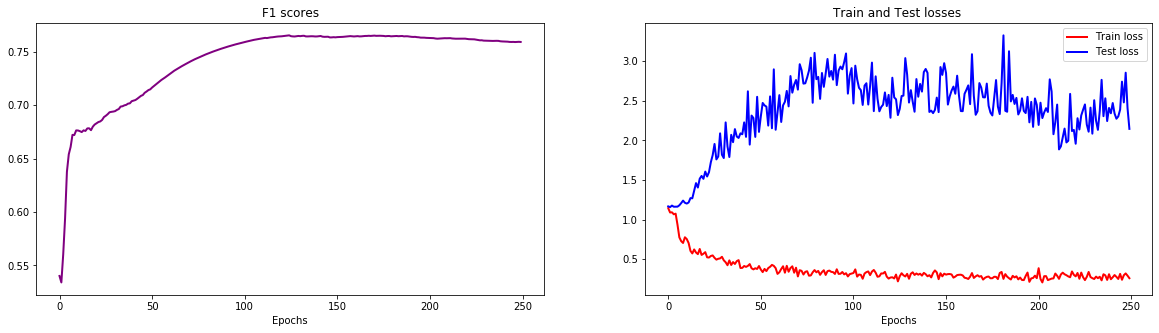

In [12]:
%run trainRNN_plot_utils.py
plot_one_input(F1_scores, trainLosses, testLosses, n_epoch)

In [14]:
# SAVE DATA
# Save the created samples, such tha the NNs can load them easily

# Save data into Python file
import pickle
with open('resultsAttention_ANM_HBTRC.pickle', 'wb') as f:
    pickle.dump( rSnpRnaA_tst_nXNS, f, pickle.HIGHEST_PROTOCOL )
    pickle.dump( rSnpRnaB_tst_nXNS, f, pickle.HIGHEST_PROTOCOL )
    pickle.dump( trainLosses, f, pickle.HIGHEST_PROTOCOL )
    pickle.dump( testLosses, f, pickle.HIGHEST_PROTOCOL )
    pickle.dump( F1_scores, f, pickle.HIGHEST_PROTOCOL )
    pickle.dump( trainAccuracy, f, pickle.HIGHEST_PROTOCOL )
    pickle.dump( attention_matrixA, f, pickle.HIGHEST_PROTOCOL )
    pickle.dump( attention_matrixB, f, pickle.HIGHEST_PROTOCOL )
    pickle.dump( tst_prediction, f, pickle.HIGHEST_PROTOCOL )
    print( 'Data saved into pickle.' )
    

Data saved into pickle.
